<a href="https://colab.research.google.com/github/james-yu2005/pytorch-practice/blob/main/pytorch_workflow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch workflow
1. prepare data,
2. build model,
3. fit model to data (train),
4. make predictions and evaluate those predictions,
5. save and load model,
6. put all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
## nn contains all of pytorch building blocks for neural networks

torch.__version__

'2.8.0+cu126'

In [2]:
# Data preparation and loading --> data is legit anything bro
# Make a straight line with known parameters

w = 0.7
b = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1) # add extra dimension at index 1
y = w * X + b
X[:20], y[:20], len(X), len(y), X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260],
         [0.4400],
         [0.4540],
         [0.4680],
         [0.4820],
         [0.4960],
         [0.5100],
         [0.5240],
         [0.5380],
         [0.5520],
         [0.5660]]),
 50,
 50,
 torch.Size([50, 1]),
 torch.Size([50, 1]))

In [3]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_test), len(X_train)

(10, 40)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='r', s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='g', s=4, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.plot()

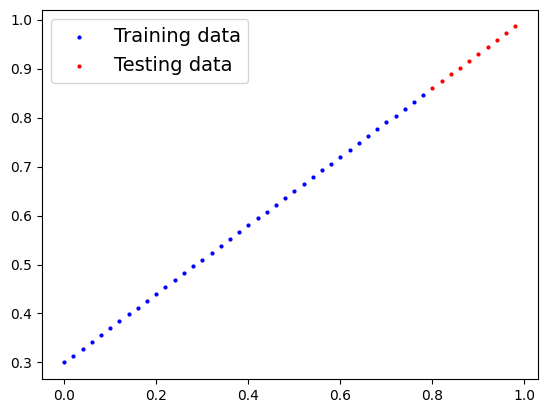

In [5]:
plot_predictions()

## Build Model

Use gradient descent and backpropagation, which pytorch takes care of for us

In [6]:
# Linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in pytorch inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # linear regression formula


## Pytorch model building essentials

torch.nn - computational graphs (a neural network can be considered a computational graph)
torch.nn.Parameter - what parameters our model should try and learn (pytorch layer oftentimes)
torch.nn.Module - base class for all neural network modules
torch.optim - where optimizers life for backpropogation
def forward() - all nn.Module subclasses require you to override this

## Checking the contents of our PyTorch Model
.parameter() use this

In [7]:
# Create a random seed
torch.manual_seed(2)

# Create an instance of the model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3923], requires_grad=True),
 Parameter containing:
 tensor([-0.2236], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3923])), ('bias', tensor([-0.2236]))])

In [9]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [10]:
# Making predictions using 'torch.inference_mode()', faster because certain things are not being saved in memory
# Similar thing with 'torch.no_grad()'
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.0903],
        [0.0981],
        [0.1060],
        [0.1138],
        [0.1217],
        [0.1295],
        [0.1373],
        [0.1452],
        [0.1530],
        [0.1609]])

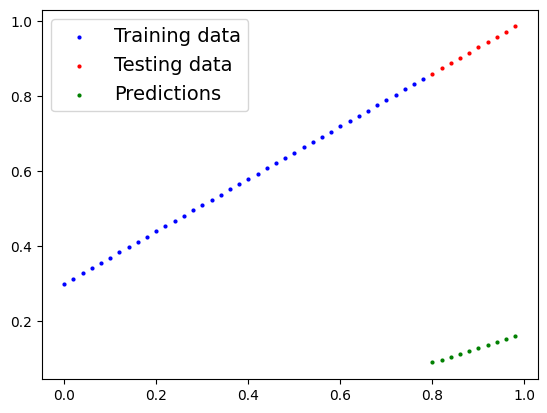

In [11]:
plot_predictions(predictions=y_preds)

## Train model
could use loss function

In [12]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimzer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

## Building a Training Loop
1. loop through data
2. Forward pass (forward propagation)
3. Calculate Loss
4. Optimize zero grad
5. Loss backwards (move back through network, calculating gradient of each of the parameters)
5. Optimizer step

In [13]:
# An epoch is one loop through data...
epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate Loss
  loss = loss_fn(y_pred, y_train)
  print(loss)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  model_0.eval() # eval mode
  with torch.inference_mode(): # turn off gradient tracking and some others things
    # 1. forward pass
    test_pred = model_0(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    print(f"Epoch  {epoch} | Loss {loss} | Test loss: {test_loss}")
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(model_0.state_dict())


tensor(0.6436, grad_fn=<MeanBackward0>)
Epoch  0 | Loss 0.6435682773590088 | Test loss: 0.7839487791061401
OrderedDict({'weights': tensor([0.3962]), 'bias': tensor([-0.2136])})
tensor(0.6320, grad_fn=<MeanBackward0>)
tensor(0.6205, grad_fn=<MeanBackward0>)
tensor(0.6090, grad_fn=<MeanBackward0>)
tensor(0.5975, grad_fn=<MeanBackward0>)
tensor(0.5860, grad_fn=<MeanBackward0>)
tensor(0.5744, grad_fn=<MeanBackward0>)
tensor(0.5629, grad_fn=<MeanBackward0>)
tensor(0.5514, grad_fn=<MeanBackward0>)
tensor(0.5399, grad_fn=<MeanBackward0>)
tensor(0.5284, grad_fn=<MeanBackward0>)
Epoch  10 | Loss 0.5283582806587219 | Test loss: 0.6492388844490051
OrderedDict({'weights': tensor([0.4352]), 'bias': tensor([-0.1136])})
tensor(0.5168, grad_fn=<MeanBackward0>)
tensor(0.5053, grad_fn=<MeanBackward0>)
tensor(0.4938, grad_fn=<MeanBackward0>)
tensor(0.4823, grad_fn=<MeanBackward0>)
tensor(0.4708, grad_fn=<MeanBackward0>)
tensor(0.4592, grad_fn=<MeanBackward0>)
tensor(0.4477, grad_fn=<MeanBackward0>)
tenso

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6891])), ('bias', tensor([0.3044]))])

In [15]:
w,b

(0.7, 0.3)

In [16]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)
y_pred_new

tensor([[0.8558],
        [0.8695],
        [0.8833],
        [0.8971],
        [0.9109],
        [0.9247],
        [0.9385],
        [0.9522],
        [0.9660],
        [0.9798]])

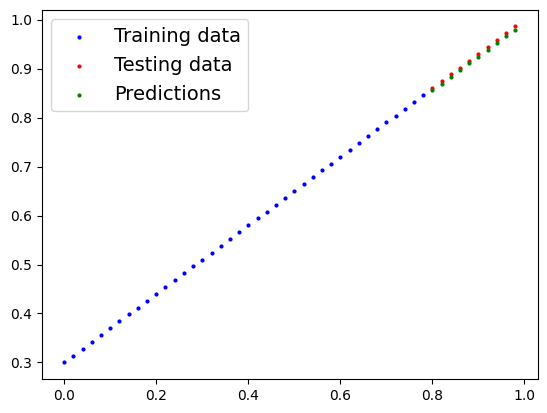

In [17]:
plot_predictions(predictions=y_pred_new)

In [18]:
import numpy as np
test_loss_values, loss_values, np.array([t.detach().numpy() for t in test_loss_values])

([tensor(0.7839),
  tensor(0.6492),
  tensor(0.5145),
  tensor(0.3798),
  tensor(0.2451),
  tensor(0.1104),
  tensor(0.0386),
  tensor(0.0283),
  tensor(0.0207),
  tensor(0.0124)],
 [tensor(0.6436, grad_fn=<MeanBackward0>),
  tensor(0.5284, grad_fn=<MeanBackward0>),
  tensor(0.4131, grad_fn=<MeanBackward0>),
  tensor(0.2979, grad_fn=<MeanBackward0>),
  tensor(0.1827, grad_fn=<MeanBackward0>),
  tensor(0.0675, grad_fn=<MeanBackward0>),
  tensor(0.0160, grad_fn=<MeanBackward0>),
  tensor(0.0125, grad_fn=<MeanBackward0>),
  tensor(0.0090, grad_fn=<MeanBackward0>),
  tensor(0.0056, grad_fn=<MeanBackward0>)],
 array([0.7839488 , 0.6492389 , 0.514529  , 0.37981907, 0.24510908,
        0.11039917, 0.03857618, 0.0282519 , 0.02066625, 0.01239371],
       dtype=float32))

[]

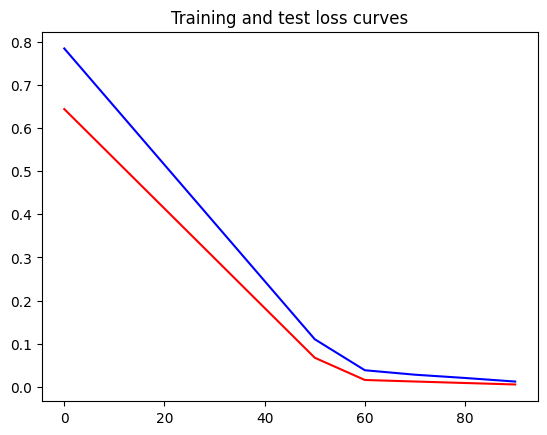

In [19]:
plt.plot(epoch_count,test_loss_values, c='b', label='Test Loss Values')
plt.plot(epoch_count,np.array([t.detach().numpy() for t in loss_values]), c='r', label="Training Loss Values")
plt.title("Training and test loss curves")
plt.plot()

In [20]:
# Saving our Pytorch model
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "simple_LR.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [21]:
!ls -1 models

simple_LR.pt


## Loading PyTorch model

In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6891])), ('bias', tensor([0.3044]))])

In [23]:
# To load in a saved state_dict, we need a new instance of our model class
loaded_model_0 = LinearRegressionModel()

print(loaded_model_0.state_dict())

OrderedDict({'weights': tensor([-0.3195]), 'bias': tensor([-1.2050])})


In [24]:
# load previous state into new model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6891])), ('bias', tensor([0.3044]))])

## Data

In [25]:
# Let it use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [27]:
torch.version.cuda

'12.6'